# PGx TIDBITS

In [5]:
from IPython.display import Image

## Case Study: Codeine

### Background
Codeine is a mild opiate analgesic that is used to releive pain and suppress cough. Codeine acts as a prodrug, which is metbolized in the liver into its active form (morphine), which is then transported into the nervous system where it binds the mu-opioid receptor with high affinity. Codeine is also metabolized into Norcodeine and Codeine-6-Glucuronide, which are much less active than morphine.  Variation in the genes that control metabolism can affect the proportion of Codeine that gets converted to morphine; and thus dictate a patient's therapteutic response as well as their potential for negative side effects or drug-drug interactions.

### Codeine Metabolism Pathway

The schematic above show the Codeine metabolism pathway.  It was generated from associations described in the biomedical literature and collected by Pharmacogenomics Knowledge Base (PharmGKB) curators through a labor intensive process to serve as a high quality source of ground truth information for clinicians and researchers. 

**But it has not been updated since 2010!**

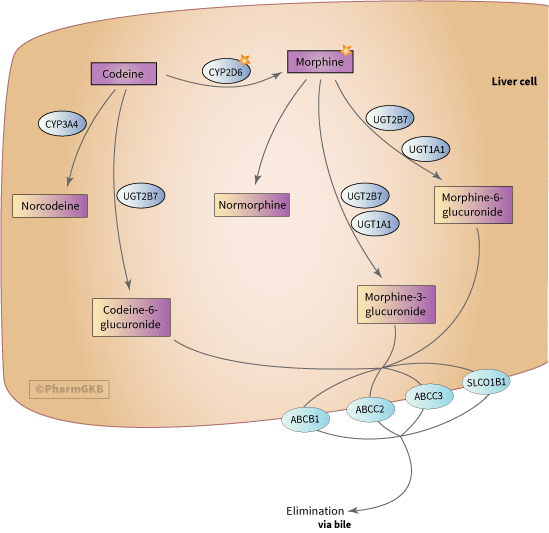

In [2]:
Image('Images/PA146123006.png')

### Problem Statement
Biomedical knowledge is dynamic and knowledge bases must incorporate new information and evidence as they become available. However, manual literature curation is time and labor intensive and resources are limited.  Pathways such as Codeine are considered "solved", while many unsolved pathways remain and new pathways and associations are constantly emerging.

### The Existing Way

PharmGKB curators currently use Pubmed and Google to search for associations and evidence contained in biomedical research journal articles.  While extremely powerful, these tools are limited in cases where (a) search parameters are nonspecific, and (a) the sought after information is not heavily referenced.

A great deal of time and effort in curation is spent parsing the results of nonspecific pubmed queries and reading through abstracts to find associations and high quality supporting or refuting evidence.

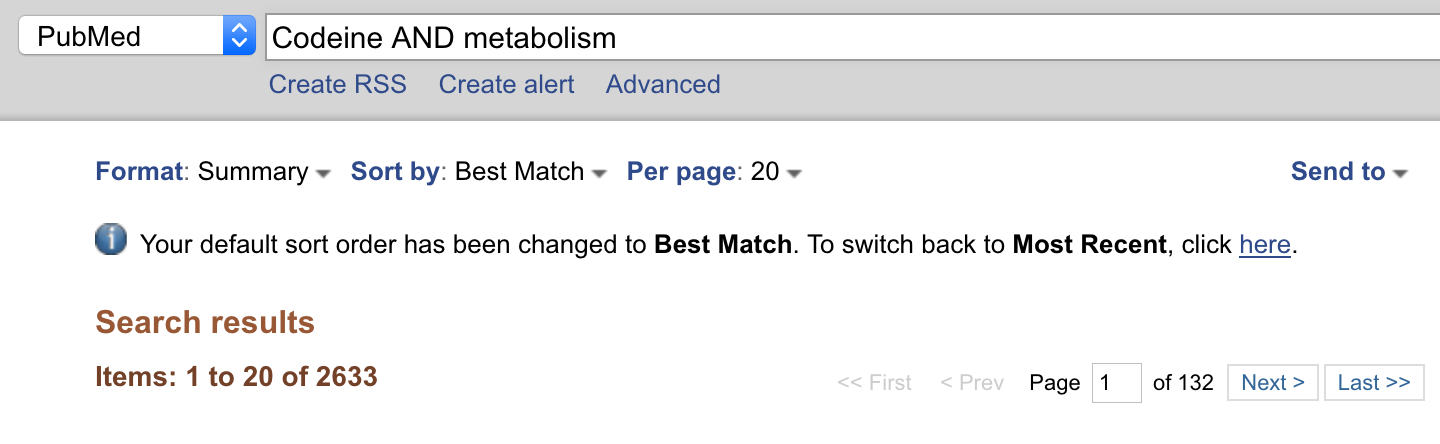

In [6]:
Image('Images/codeine_pubmed_old.png')

### The Translator Way
**A WAY TO** identify new associations and evidence in pharmacogenomics pathways **FOR** PharmGKB curators **THAT** improves the throughput and specificity of Pubmed searches.

The following is an example analysis that leverages human curated knowledge (extracted and structured by professional curators with expertise in the domain) and machine curated knowledge (extracted and structured using natural language processing algorithms) that has been semantically modeled to support machine readability in advanced querying.

In [37]:
chemical = ['Codeine']

### Step 1. Query SMPDB API

In [38]:
from pprint import pprint
from __future__ import print_function
from tkbeacon import build, KnowledgeSource
from tkbeacon.rest import ApiException

def get_concepts(query):
    b = build(KnowledgeSource.SMPDB)
    terms = [i.lower() for i in query]
    concepts = b.get_concepts(keywords=terms)
    return [b.get_concept_details(i.id) for i in concepts if i.name.lower() in terms]

def get_genes(query):
    b = build(KnowledgeSource.SMPDB)
    concepts = get_concepts(query)
    query_ids = [i.id for i in concepts]
    statements = b.get_statements(s=query_ids, edge_label='related_to', t_categories=['protein'])
    return statements

In [39]:
concepts = get_concepts(chemical)
smpdb_genes = get_genes(query=chemical)
for i in smpdb_genes:
    print(i.subject.name, i.predicate.edge_label, i.object.name)

Codeine related_to Cytochrome P450 3A4
Codeine related_to Cytochrome P450 2D6
Codeine related_to UDP-glucuronosyltransferase 2B7


### Step 2. Query GNBR API

In [14]:
import gnbr_beacon
gnbr_concepts = gnbr_beacon.ConceptsApi()
gnbr_statements = gnbr_beacon.StatementsApi()

concepts = gnbr_concepts.get_concepts(keywords=chemical)
ids = [i.id for i in concepts]
gnbr_genes = gnbr_statements.get_statements(s=ids, t_categories=['Gene'])

### Step 3. Find New Associations

In [20]:
mapped_genes = gnbr_concepts.get_concepts(keywords=[i.object.name for i in smpdb_genes])
mapped_ids = [i.id for i in mapped_genes]

In [23]:
new_associations = [i for i in gnbr_genes if i.object.id not in mapped_ids]
for i in new_associations:
    print(i.id, '--', i.subject.name, 'related_to', i.object.name)

33560061 -- codeine related_to OCT1
33560063 -- codeine related_to UGT2B4
33560059 -- codeine related_to G6PD
33560062 -- codeine related_to CO2
33560056 -- codeine related_to CYP2D
33560060 -- codeine related_to PGD2
33560065 -- codeine related_to GH


### Step 4. Inspect Evidence (UGT2B4)

In [12]:
evidence = gnbr_statements.get_statement_details(statement_id=33560063)
pprint(evidence)

{'annotation': None,
 'evidence': [{'date': None,
               'evidence_type': 'http://purl.obolibrary.org/obo/ECO_0000204',
               'id': 'PUBMED:12920168',
               'name': 'Codeine is not a useful UGT2B7 probe substrate because '
                       'of significant glucuronidation by UGT2B4 .',
               'uri': 'https://www.ncbi.nlm.nih.gov/pubmed/12920168'},
              {'date': None,
               'evidence_type': 'http://purl.obolibrary.org/obo/ECO_0000204',
               'id': 'PUBMED:12920168',
               'name': 'Codeine was glucuronidated equally well by UGT2B4 and '
                       'UGT2B7 .',
               'uri': 'https://www.ncbi.nlm.nih.gov/pubmed/12920168'}],
 'id': '33560063',
 'is_defined_by': None,
 'provided_by': None,
 'qualifiers': None}


### Step 5. Pubmed Follow Up

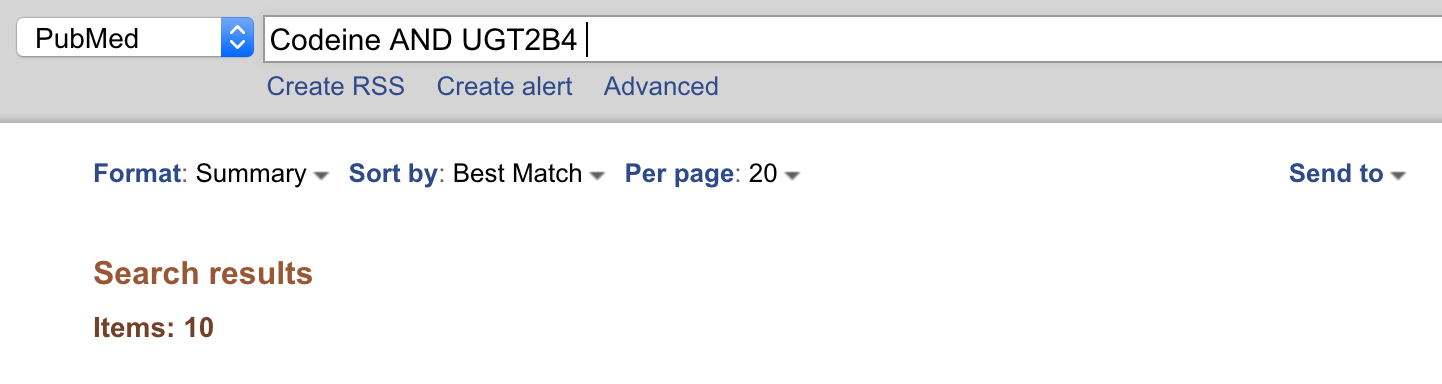

In [18]:
Image('Images/codeine_pubmed_new.png')

## Conclusion
In this TIDBIT we demonstrated how translator can be used to improve the workflow of pharmGKB curators by identifying a new PK gene in the Codeine metabolism pathway. Use of Translator led to drastic improvement in the specificity of Pubmed queries used to gather evidence and over 100x reduction in the number of articles returned to curators. We have notified curators of the evidence for UGT2B4 as a metabolizer of Codeine, and they have agreed to review the articles and update the Codeine metbolism pathway.

# End

In [27]:
from Bio import Entrez

def search(query):
    Entrez.email = 'your.email@example.com'
    handle = Entrez.esearch(db='pubmed', 
                            sort='relevance', 
                            retmax='20',
                            retmode='xml', 
                            term=query)
    results = Entrez.read(handle)
    return results
refs = search('Codeine AND UGT2B4')

pprint(stuff['Count'])

'10'


In [33]:
refs

DictElement({'Count': '10', 'RetMax': '10', 'RetStart': '0', 'IdList': ['22092298', '20484152', '21551257', '15319348', '12920168', '27372715', '27474751', '25684194', '27692933', '23554428'], 'TranslationSet': [DictElement({'From': 'Codeine', 'To': '"codeine"[MeSH Terms] OR "codeine"[All Fields]'}, attributes={})], 'TranslationStack': [DictElement({'Term': '"codeine"[MeSH Terms]', 'Field': 'MeSH Terms', 'Count': '6571', 'Explode': 'Y'}, attributes={}), DictElement({'Term': '"codeine"[All Fields]', 'Field': 'All Fields', 'Count': '6627', 'Explode': 'N'}, attributes={}), 'OR', 'GROUP', DictElement({'Term': 'UGT2B4[All Fields]', 'Field': 'All Fields', 'Count': '147', 'Explode': 'N'}, attributes={}), 'AND'], 'QueryTranslation': '("codeine"[MeSH Terms] OR "codeine"[All Fields]) AND UGT2B4[All Fields]'}, attributes={})

In [32]:
def fetch_details(id_list):
    ids = ','.join(id_list)
    Entrez.email = 'your.email@example.com'
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=ids)
    results = Entrez.read(handle)
    return results

fetch_details(refs['IdList'])

## Problem Statement
From the [PharmGKB FAQ](https://www.pharmgkb.org/page/faqs#what-is-the-pharmgkb).

> **Does PharmGKB have information on all the variants associated with drug response?**
>
>No, curating genomic variant data is a highly time consuming process. While PharmGKB strives to routinely curate those associations reported in the major pharmacogenomics journals as well as historically important studies encountered during literature reviews for VIPs and pathways, we acknowledge that we cannot manually curate the literature in its entirety. If you see something you think we should have, please send us feedback.

## Need Statement
**A way to** identify pharmacogenomic associations and accompanying evidence...

**for** biomedical researchers...

**that** improves some measureable benchmark(s).

To illustrate, a Pubmed search for ["Thioguanine AND RAC1"](https://www.ncbi.nlm.nih.gov/pubmed/?term=thioguanine+RAC1) returns 8 highly relevant results, while a search for ["Thioguanine AND target"](https://www.ncbi.nlm.nih.gov/pubmed/?term=thioguanine+target) returns 8 pages of results.
A great deal of time and effort in curation is spent parsing the results of nonspecific searches and reading abstracts to assess relevance and reliability.

#### CDP2D7
This one was removed from PharmGKB after it was shown to be a psuedogene that did not replicate after the initial studies identifying it as a PK Gene. However, this is not uncontroversial. A recent study in drisophila suggests the existence of pseudo-psuedogenes, which are only expressed in neural tissues.

In [13]:
evidence = gnbr_statements.get_statement_details(statement_id=33560056)
pprint(evidence)

{'annotation': None,
 'evidence': [{'date': None,
               'evidence_type': 'http://purl.obolibrary.org/obo/ECO_0000204',
               'id': 'PUBMED:28837793',
               'name': 'Brain CYP2D metabolizes codeine to morphine , a '
                       'bioactivation step required for codeine analgesia .',
               'uri': 'https://www.ncbi.nlm.nih.gov/pubmed/28837793'},
              {'date': None,
               'evidence_type': 'http://purl.obolibrary.org/obo/ECO_0000204',
               'id': 'PUBMED:17017525',
               'name': 'Genotyping revealed the presence of the frame-shift '
                       'mutation 138delT only in those subjects who expressed '
                       'the brain variant CYP2D7 , which metabolizes codeine '
                       'exclusively to morphine unlike hepatic CYP2D6 that '
                       'metabolizes codeine to nor codeine and morphine .',
               'uri': 'https://www.ncbi.nlm.nih.gov/pubmed/17017525'},
 

##### OCT1

In [14]:
evidence = gnbr_statements.get_statement_details(statement_id=33560061)
pprint(evidence)

{'annotation': None,
 'evidence': [{'date': None,
               'evidence_type': 'http://purl.obolibrary.org/obo/ECO_0000204',
               'id': 'PUBMED:27128732',
               'name': 'Increased odds ratio of early discontinuation of '
                       'metformin was only associated with codeine , an '
                       'inhibitor of organic_cation_transporter_1 in both '
                       'cohorts -LSB- adjusted odds ratio -LRB- OR -RRB- in '
                       'Danish cohort -LRB- 95 % CI -RRB- : 1.13 -LRB- '
                       '1.02-1.26 -RRB- , adjusted OR in American cohort -LRB- '
                       '95 % CI -RRB- : 1.32 -LRB- 1.19-1.47 -RRB- -RSB- .',
               'uri': 'https://www.ncbi.nlm.nih.gov/pubmed/27128732'}],
 'id': '33560061',
 'is_defined_by': None,
 'provided_by': None,
 'qualifiers': None}
